# Creating Tracks

# Read in the 2012 - 2013 Seasonal Slice Data

These are all of the attributes and spatial information associated with 3-hr snapshots of SWE accumulation.

Smallest area will be 100 sq. km.

Will be visualizing data from 1/26/2013 to 1/28/2013 at 00 UTC.

If you get a shapely error reading in the file, change the first line below to access prior version:

```
paper_preproc = pickle.load(open("../example_data/pre_CTRL_2012_2013_py.pkl", 'rb'))

In [1]:
import pickle

ds = pickle.load(open("../example_data/CTRL_2012_2013_010_results_py312.pkl", 'rb'))

ds.head()

,area,convex_area,coords,coords_50p,coords_90p,eccentricity,geometry,intensity_variance,major_axis_length,max_intensity,...,solidity,start_day,start_hour,start_month,start_time,start_year,xmax,xmin,ymax,ymin
0,2032.0,2384.0,"[[937, 345], [937, 346], [938, 344], [938, 345...","[[940, 342], [940, 343], [940, 344], [941, 341...",[],0.741318,"POLYGON ((943 338, 939 342, 937 345, 937 346, ...",0.192474,64.455741,1.836239,...,0.852349,2,6,10,2012-10-02 06:00:00,2012,356,338,950,937
1,688.0,896.0,"[[944, 386], [944, 387], [945, 385], [945, 386...","[[946, 386], [947, 385], [947, 386], [948, 384...",[],0.844213,"POLYGON ((948 383, 945 385, 944 386, 944 387, ...",0.049803,47.533864,0.996987,...,0.767857,2,6,10,2012-10-02 06:00:00,2012,390,383,954,944
2,128.0,128.0,"[[947, 334], [947, 335], [948, 333], [948, 334...","[[949, 333]]",[],0.884338,"POLYGON ((949 332, 947 334, 947 335, 948 335, ...",0.018417,18.031576,0.520575,...,1.000000,2,6,10,2012-10-02 06:00:00,2012,335,332,949,947
3,1040.0,1440.0,"[[951, 334], [951, 335], [951, 336], [951, 337...","[[952, 333], [952, 334], [952, 335], [953, 329...","[[953, 330], [953, 331], [953, 332], [953, 333...",0.833672,"POLYGON ((953 327, 952 330, 951 334, 951 337, ...",4.032813,55.758451,7.914831,...,0.722222,2,6,10,2012-10-02 06:00:00,2012,337,327,961,951
4,160.0,192.0,"[[960, 321], [961, 321], [962, 320], [962, 321...","[[963, 321]]",[],0.826857,"POLYGON ((962 320, 960 321, 962 322, 964 322, ...",0.011030,19.374035,0.463909,...,0.833333,2,6,10,2012-10-02 06:00:00,2012,322,320,964,960


# Here are the functions and libraries used to write the tracking code

In [2]:
import numpy as np
import os
from scipy.spatial.distance import pdist
from copy import deepcopy

feature_list = ['area', 'convex_area', 'eccentricity', 'mean_intensity', 'max_intensity',
                'intensity_variance', 'major_axis_length', 'minor_axis_length',
                'solidity']

def get_normalization(norm_df):
    r"""Returns the maximum value for each variable in feature_list for the
    purposes of normalizing the variable values for similarity calculations.
    ----------
    norm_df: DataFrame
        Slice data from which to extract maximum values.
        
    Returns
    -------
    maxes: (X, Y) ndarray
        List of maximum values in same order as 'feature_list'.
    """
    maxes = []

    for col in feature_list:
        maxes.append(np.max(norm_df[col].values))
        
    return maxes

def create_tracks(df_slices, date_range):
    r"""Associates slices in space and time by visiting each time in the specified
    range, selecting 3-hr slices from that time and the next time, and checking if
    any slices overlap.  For multiple overlaps, ties are broken by calculating 
    the smallest euclidean distance in the 9-D variable space.  Returns slices
    with unique storm identifiers. df_slices is not modified.
    ----------
    df_slices: GeoDataFrame
        Data frame with slice information.  Must have all values in "feature_list",
        as well as the maximum extent of the slice stored as a polygon in 'geometry',
        and datetime information.  The datetime must be the index field.
    date_range: pandas date_range object
        All time steps to visit.
    Returns
    -------
    geo_df: GeoDataFrame
    Modifies a copy of 'df_slices' only by adding a unique identifier to denote what
    unique track the slice belongs to.
    """
    geo_df = deepcopy(df_slices)

    normalization = get_normalization(geo_df)

    geo_df['storm_num'] = np.nan

    storm_num = 0

    print("finding current times")
    cur_time = geo_df[geo_df['datetime'] == date_range[0].to_pydatetime()]

    print("setting initial storm numbers")
    #set storm numbers for the first time period
    for idx, row in cur_time.iterrows():

        geo_df.loc[idx, 'storm_num'] = storm_num

        storm_num += 1

    print("running storm tracking")
    #run until the second to last time period
    for i in range(len(date_range)-1):

        print("cur_time", date_range[i], "next_time", date_range[i+1])
            
        cur_time = geo_df[geo_df['datetime'] == date_range[i].to_pydatetime()].copy()

        next_time = geo_df[geo_df['datetime'] == date_range[i+1].to_pydatetime()].copy()

        if len(cur_time) > 0 and len(next_time) > 0:

            distance_matrix = np.ones(shape=(len(cur_time), len(next_time)), dtype=float) * np.nan

            for cc, (cid, crow) in enumerate(cur_time.iterrows()):
                for nc, (nid, nrow) in enumerate(next_time.iterrows()):

                    if crow['geometry'].intersects(nrow['geometry']):

                        cfeat = (crow[feature_list].values / normalization).astype(float)
                        nfeat = (nrow[feature_list].values / normalization).astype(float)
                        
                        distance_matrix[cc, nc] = pdist([cfeat, nfeat])[0]

            a = np.copy(distance_matrix)

            while np.sum(~np.isnan(a)) > 0:

                track, candidate = np.where(a == np.nanmin(a))

                c_idx = next_time[candidate[0]:candidate[0]+1].index[0]
                t_idx = cur_time[track[0]:track[0]+1].index[0]

                next_time.loc[c_idx, 'storm_num'] = geo_df.loc[t_idx, 'storm_num']

                geo_df.loc[c_idx, 'storm_num'] = geo_df.loc[t_idx, 'storm_num']

                a[track[0], :] = np.nan

                a[:, candidate[0]] = np.nan

        new_storms = next_time[next_time['storm_num'].isnull()]

        for idx, row in new_storms.iterrows():

            geo_df.loc[idx, 'storm_num'] = storm_num

            storm_num += 1

    return geo_df

# Send the slice data to the tracking function

In [3]:
import pandas as pd

ds['datetime'] = pd.to_datetime(ds.start_time)

#Add some time before and after to remove temporal edge effects
#when comparing to the paper data
start_time = "2013-01-24 00:00:00"
end_time = "2013-01-30 00:00:00"
            
drng = pd.date_range(start=start_time, end=end_time, freq='3h')

track_data = create_tracks(ds, drng)

track_data.head()

finding current times
setting initial storm numbers
running storm tracking
cur_time 2013-01-24 00:00:00 next_time 2013-01-24 03:00:00
cur_time 2013-01-24 03:00:00 next_time 2013-01-24 06:00:00
cur_time 2013-01-24 06:00:00 next_time 2013-01-24 09:00:00
cur_time 2013-01-24 09:00:00 next_time 2013-01-24 12:00:00
cur_time 2013-01-24 12:00:00 next_time 2013-01-24 15:00:00
cur_time 2013-01-24 15:00:00 next_time 2013-01-24 18:00:00
cur_time 2013-01-24 18:00:00 next_time 2013-01-24 21:00:00
cur_time 2013-01-24 21:00:00 next_time 2013-01-25 00:00:00
cur_time 2013-01-25 00:00:00 next_time 2013-01-25 03:00:00
cur_time 2013-01-25 03:00:00 next_time 2013-01-25 06:00:00
cur_time 2013-01-25 06:00:00 next_time 2013-01-25 09:00:00
cur_time 2013-01-25 09:00:00 next_time 2013-01-25 12:00:00
cur_time 2013-01-25 12:00:00 next_time 2013-01-25 15:00:00
cur_time 2013-01-25 15:00:00 next_time 2013-01-25 18:00:00
cur_time 2013-01-25 18:00:00 next_time 2013-01-25 21:00:00
cur_time 2013-01-25 21:00:00 next_time 2

,area,convex_area,coords,coords_50p,coords_90p,eccentricity,geometry,intensity_variance,major_axis_length,max_intensity,...,start_hour,start_month,start_time,start_year,xmax,xmin,ymax,ymin,datetime,storm_num
0,2032.0,2384.0,"[[937, 345], [937, 346], [938, 344], [938, 345...","[[940, 342], [940, 343], [940, 344], [941, 341...",[],0.741318,"POLYGON ((943 338, 939 342, 937 345, 937 346, ...",0.192474,64.455741,1.836239,...,6,10,2012-10-02 06:00:00,2012,356,338,950,937,2012-10-02 06:00:00,NaN
1,688.0,896.0,"[[944, 386], [944, 387], [945, 385], [945, 386...","[[946, 386], [947, 385], [947, 386], [948, 384...",[],0.844213,"POLYGON ((948 383, 945 385, 944 386, 944 387, ...",0.049803,47.533864,0.996987,...,6,10,2012-10-02 06:00:00,2012,390,383,954,944,2012-10-02 06:00:00,NaN
2,128.0,128.0,"[[947, 334], [947, 335], [948, 333], [948, 334...","[[949, 333]]",[],0.884338,"POLYGON ((949 332, 947 334, 947 335, 948 335, ...",0.018417,18.031576,0.520575,...,6,10,2012-10-02 06:00:00,2012,335,332,949,947,2012-10-02 06:00:00,NaN
3,1040.0,1440.0,"[[951, 334], [951, 335], [951, 336], [951, 337...","[[952, 333], [952, 334], [952, 335], [953, 329...","[[953, 330], [953, 331], [953, 332], [953, 333...",0.833672,"POLYGON ((953 327, 952 330, 951 334, 951 337, ...",4.032813,55.758451,7.914831,...,6,10,2012-10-02 06:00:00,2012,337,327,961,951,2012-10-02 06:00:00,NaN
4,160.0,192.0,"[[960, 321], [961, 321], [962, 320], [962, 321...","[[963, 321]]",[],0.826857,"POLYGON ((962 320, 960 321, 962 322, 964 322, ...",0.011030,19.374035,0.463909,...,6,10,2012-10-02 06:00:00,2012,322,320,964,960,2012-10-02 06:00:00,NaN


# Examine the raw tracks output by the function.

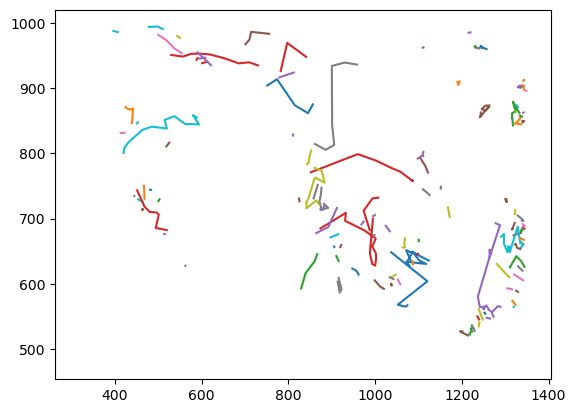

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

start_time = "2013-01-26 00:00:00"

end_time = "2013-01-28 00:00:00"

example_tracks_sub = track_data[(track_data.start_time >= start_time) & (track_data.start_time <= end_time)]

for storm_num, storm in example_tracks_sub.groupby('storm_num'):
    
    cy = storm.geometry.centroid.x
    cx = storm.geometry.centroid.y
    
    plt.plot(cx, cy, '-')

# Read in track data used in this paper

In [5]:
tracks = pickle.load(open("../example_data/CTRL_2012_2013.pkl", 'rb'))

tracks_sub = tracks[(tracks.start_time >= start_time) & (tracks.start_time <= end_time)]

/tmp/ipykernel_2816523/2001510282.py:1: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  tracks = pickle.load(open("../example_data/CTRL_2012_2013.pkl", 'rb'))


# Examine the raw tracks output from the paper data.

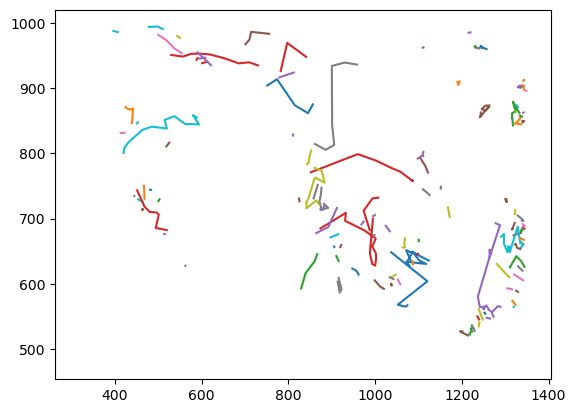

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for storm_num, storm in tracks_sub.groupby('storm_num'):
    
    cy = storm.geometry.centroid.x
    cx = storm.geometry.centroid.y
    
    plt.plot(cx, cy, '-')

# Compare number of tracks in the example data and the paper data

In [7]:
print("Paper data tracks count:", tracks_sub.storm_num.nunique())

print("Example data tracks count:", example_tracks_sub.storm_num.nunique())

Paper data tracks count: 467
Example data tracks count: 467


# Plot only those tracks with at least 8 slices (24 hours)

## Paper data:

long paper data track count: 11


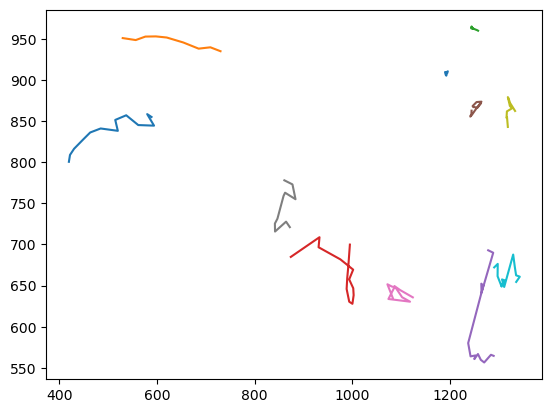

In [8]:
paper_data_count = 0

for storm_num, storm in tracks_sub.groupby('storm_num'):
    
    if len(storm) >= 8:
        cy = storm.geometry.centroid.x
        cx = storm.geometry.centroid.y

        plt.plot(cx, cy, '-')
        
        paper_data_count += 1
        
print("long paper data track count:", paper_data_count)

## Example data

example data track count: 11


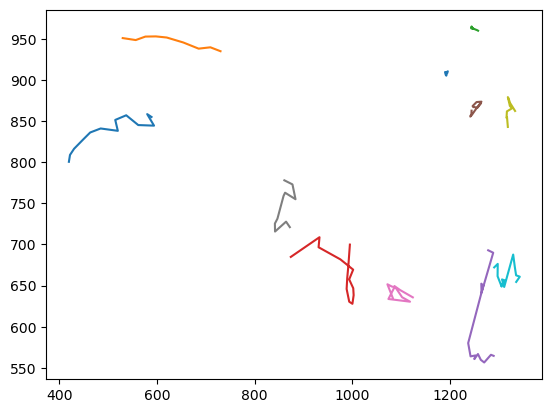

In [9]:
example_data_count = 0

for storm_num, storm in example_tracks_sub.groupby('storm_num'):
    
    if len(storm) >= 8:
        cy = storm.geometry.centroid.x
        cx = storm.geometry.centroid.y

        plt.plot(cx, cy, '-')
        
        example_data_count += 1
        
print("example data track count:", example_data_count)

# These data are then preprocessed.. see applicable notebook for those codes.